Fit CNN in PyTorch
===


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
from torchmetrics import R2Score
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
import PIL
from PIL import Image
from skimage import io, transform
from glob import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 10

# size of test and validation set
n_test = 90

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 500
num_epochs_ft = 500

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5 
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 1 * 10 ** loglr
lr_ft = 1e-4 #0.0001

# create categories of stones for stratified train test split
categories = [i for i in range(30) for j in range(12)] # creates 360 list items like so: [0, 0, 0, 0, ... 29, 29, 29, 29]

IMG_360 = '../sanders_2018/360 Rocks/'
IMG_120 = '../sanders_2018/120 Rocks/'
MDS_360 = '../finetuning_torchvision_data/mds_360.csv'
CHECKPOINTS = 'CNN_checkpoints/'
PATH_IM = CHECKPOINTS + 'state_dict_intermediate_model.pt'
PATH_FT = CHECKPOINTS + 'state_dict_finetuned_model.pt'


print("Device is", device)

Device is cuda


## Functions, classes

In [2]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    r2score = R2Score(num_outputs=8).to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {str(epoch + 1).rjust(len(str(num_epochs)))}/{num_epochs}', end=": ")
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2score(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 
            # print only if phase is validation
            if phase == "val":
                print(f'Loss = {epoch_loss: .4f}, Score = {epoch_acc: .4f}, lr = {lr: .4e}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(datasets.VisionDataset):
    def __init__(self, df, root_dir, transform=None):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = PIL.Image.fromarray(img)  
        label = deepcopy(self.df.iloc[ix,1:].tolist())
        label = torch.tensor(label).float()
        #img = self.preprocess_input(img)
        img = self.transform(img)
        return img.to(device), label
 
    
class PredictionData(datasets.VisionDataset): # TODO: lots of redundant code. integrate this into above RocksData dataset
    def __init__(self, img_paths):
        super(PredictionData).__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.img_paths = img_paths
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, ix):
        img = cv2.imread(self.img_paths[ix])/255.
        img = self.preprocess_input(img)
        return img
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device) 
    
    
def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")
        

def load_pretrained_model(e=None, model_type=None):
    
    if (model_type == None) | (model_type == "resnet"):
        model = models.resnet50()
    elif model_type == "regnet":
        model = models.regnet_y_16gf()
    set_parameter_requires_grad(model, feature_extract_ft)
    num_ftrs = model.fc.in_features
    new_layers = OutputLayers(n_layers, num_ftrs, n_dense, dropout)
    model.fc = new_layers # replace last layer
    
    if model_type == None:
        if e == None:
            checkpoint = torch.load(CHECKPOINTS + f'state_dict_intermediate_model.pt')
        else:
            checkpoint = torch.load(CHECKPOINTS + f'state_dict_ensemble_model_{e+1}.pt')
    else:
        checkpoint = torch.load(CHECKPOINTS + f'state_dict_intermediate_{model_type}.pt')
    
    model.load_state_dict(checkpoint)

    # Send the model to GPU
    return model.to(device)


def predict(model, data_loader, unlabeled=False):
    """Computes predictions for a given mnodel and dataset"""
    
    model.eval()

    outputs = list()
    since = time.time()
    with torch.no_grad():
        if unlabeled:
            for inputs in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.to("cpu").squeeze().numpy())
        else:
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(output.to("cpu").squeeze().numpy())

    return np.array(outputs)

## Prepare Data

<div class="alert alert-warning" role="alert">Note: Stratified split still to be implemented!</div>

### Define image transforms

In [3]:
# define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=(0.2, 0.2, 0.2, 0.2), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Create dataset and dataloaders

In [4]:
df = pd.read_csv(MDS_360)


# split data: train vs test
(train, test,
categories_train_, categories_test) = train_test_split(df,
                                                       categories,
                                                       test_size=n_test,
                                                       stratify=categories,
                                                       random_state=0)

# split train set again: train vs validate
train, val = train_test_split(train,
                              test_size=n_test,
                              stratify=categories_train_, 
                              random_state=0)

# create image datasets
train_dataset = RocksData(train.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["train"])
val_dataset = RocksData(val.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["val"])
test_dataset = RocksData(test.reset_index(drop=True), root_dir=IMG_360, transform=data_transforms["val"])
pred_dataset = PredictionData(glob(IMG_120+'*.jpg'))

## Adapt model

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [5]:
from collections import OrderedDict

class OutputLayers(nn.Sequential):
    def __init__(self, n_layers, num_ftrs, n_dense, dropout):
        super().__init__(self.init_modules(n_layers, num_ftrs, n_dense, dropout))


    def init_modules(self, n_layers, num_ftrs, n_dense, dropout):
        modules = OrderedDict()
        
        i = 0
        modules[f"dropout_{i}"] = nn.Dropout(p=dropout)
        modules[f"fc_{i}"] = nn.Linear(num_ftrs, n_dense)
        
        for i in range(1, n_layers):           
            modules[f"relu_{i}"] = nn.ReLU(inplace=True)
            modules[f"batchnorm_{i}"] = nn.BatchNorm1d(n_dense)
            modules[f"dropout_{i}"] = nn.Dropout(p=dropout)
            modules[f"fc_{i}"] = nn.Linear(n_dense, n_dense)

        modules[f"relu_{i+1}"] = nn.ReLU(inplace=True)
        modules[f"batchnorm_{i+1}"] = nn.BatchNorm1d(n_dense)
        modules[f"dropout_{i+1}"] = nn.Dropout(p=dropout)
        modules[f"fc_{i+1}"] = nn.Linear(n_dense, n_dim)

        return modules

## Train one model ...
... for testing purposes, comparing learning rates etc.

Intermediate model

Epoch   1/500: Loss =  6.5178, Score = -0.0205, lr =  6.0247e-03
Epoch   2/500: Loss =  5.1725, Score =  0.1597, lr =  6.0247e-03
Epoch   3/500: Loss =  4.3639, Score =  0.2883, lr =  6.0247e-03
Epoch   4/500: Loss =  3.8733, Score =  0.3602, lr =  6.0247e-03
Epoch   5/500: Loss =  3.7746, Score =  0.3717, lr =  6.0247e-03
Epoch   6/500: Loss =  3.8646, Score =  0.3638, lr =  6.0247e-03
Epoch   7/500: Loss =  3.6296, Score =  0.3984, lr =  6.0247e-03
Epoch   8/500: Loss =  3.4515, Score =  0.4250, lr =  6.0247e-03
Epoch   9/500: Loss =  3.3378, Score =  0.4421, lr =  6.0247e-03
Epoch  10/500: Loss =  3.2386, Score =  0.4573, lr =  6.0247e-03
Epoch  11/500: Loss =  3.2053, Score =  0.4639, lr =  6.0247e-03
Epoch  12/500: Loss =  3.1935, Score =  0.4700, lr =  6.0247e-03
Epoch  13/500: Loss =  3.1780, Score =  0.4795, lr =  6.0247e-03
Epoch  14/500: Loss =  3.2614, Score =  0.4706, lr =  6.0247e-03
Epoch  15/500: Loss =  3.1241, Score =  0.4851, lr =  6.0247e-03
Epoch  16/500: Loss =  3.

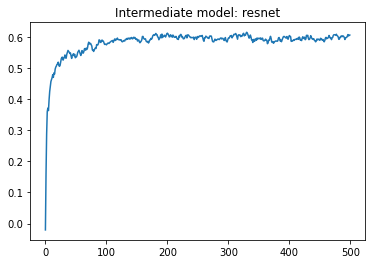

In [6]:
num_epochs_one = 500
lr_one = 6.0247e-03

torch.manual_seed(0)

model_type = "resnet" # "resnet"

# Intermediate model

if model_type == "resnet":
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
elif model_type == "regnet":
    model = models.regnet_y_16gf(weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)
    
set_parameter_requires_grad(model, feature_extract_im)
num_ftrs = model.fc.in_features
new_layers = OutputLayers(n_layers, num_ftrs, n_dense, dropout)
model.fc = new_layers # replace last layer

# Send the model to GPU
model = model.to(device)

# create dataloaders with specific batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
dataloaders_dict = {"train":train_loader,"val":val_loader}

# Create Optimizer and define params to update
params_to_update = model.parameters()
if feature_extract_im:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)


# Instantiate optimizer for intermediate model
optimizer = optim.Adam(params_to_update, lr = lr_one)

# learning rate scheduler
#scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95, verbose=True)

# Setup the loss fxn
criterion = get_criterion("L2")

# Train and evaluate intermediate model
model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_one)

# Save intermediate model
torch.save(model.state_dict(), CHECKPOINTS + f'state_dict_intermediate_{model_type}.pt')

# Plot learning curve
plt.plot(hist)
plt.title(f'Intermediate model: {model_type}')
plt.show()

Finetuned model (needs weights of intermediate model)

In [ ]:
num_epochs_one = 500
lr_one = 1e-4

#torch.backends.cudnn.benchmark = False
torch.manual_seed(1)

# load intermediate model

model_type = "regnet" # "resnet" or None

model = load_pretrained_model(model_type=model_type)

# create dataloaders with specific batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
dataloaders_dict = {"train":train_loader,"val":val_loader}

# Create Optimizer and define params to update
params_to_update = model.parameters()
if feature_extract_ft:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

# Instantiate optimizer for finetuning
optimizer = optim.SGD(params_to_update, lr=lr_one, momentum=0.9)

# Setup the loss fxn
criterion = get_criterion("L2")

# Train and evaluate fine tuned model
model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_one)

# Save finetuned model
#torch.save(model.state_dict(), CHECKPOINTS + f'state_dict_finetuned_{model_type}.pt')

# Plot learning curve
plt.plot(hist)
plt.title(f'Finetuned {model_type}')
plt.show()

## Train ensemble

In [ ]:
lr_ft = 5e-4 # override previously defined lr for finetuning

new_im_each_epoch = False # False means using the same intermediate model for all ensemble models

In [ ]:
for e in range(2, n_ensemble + 1):
    
       
    # each epoch a new intermediate model?
    if new_im_each_epoch:

        # Intermediate model
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        set_parameter_requires_grad(model, feature_extract_im)
        num_ftrs = model.fc.in_features
        new_layers = OutputLayers(n_layers, num_ftrs, n_dense, dropout)
        model.fc = new_layers # replace last layer

        # Send the model to GPU
        model = model.to(device)

        # create datalaoders with specific batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
        val_loader = DataLoader(val_dataset, batch_size=batch_size_im)
        dataloaders_dict = {"train":train_loader,"val":val_loader}

        # Create Optimizer and define params to update
        params_to_update = model.parameters()
        if feature_extract_im:
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    #print("\t",name)

        else:
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    #print("\t",name)
                    ...

        # Instantiate optimizer for intermediate model
        optimizer = optim.Adam(params_to_update, lr=lr_im)

        # Setup the loss fxn
        criterion = get_criterion('L2')

        # Initial training and evaluate
        model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_im)

        # Plot learning curve
        plt.plot(hist)
        plt.title(f'Intermediate model {e}')
        plt.show()

        # Save intermediate model
        torch.save(model.state_dict(), PATH_IM)
        
    else:
        model = load_pretrained_model()

    # fine tuning
    
    # create dataloaders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":val_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr=lr_ft, momentum=0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)


## Load checkpoints and get predictions for validation and test sets

### Create dataloaders for inference

In [ ]:
pred_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

### Run ensemble models (CNNs) ...
... to collect their individual predictions

In [ ]:
test_pred = []
rocks_120_pred = []
n_ensemble = 1
for e in range(n_ensemble):
    model = load_pretrained_model(e)
    pred = predict(model, test_loader)
    test_pred.append(pred)
    rocks_120_pred.append(predict(model, pred_loader, unlabeled=True))
    

test_pred = np.mean(test_pred, 0)
rocks_120_pred = np.mean(rocks_120_pred, 0)

In [ ]:
rocks_120_pred.shape

---
### Run meta learner (LinearRegression, ElasticNet or similar) ...
... to find optimally weighted mean of CNN predictions.

<div class="alert-warning">According to their paper Sanders & Nosofsky were not using a meta-learner, they were training an ensemble of 10 models and averaging them.</div>

$Y_{pred} =  b_0 + b_1 Y_{pred_1} + b_2 Y_{pred_2}$

But first we start simple ...

In [ ]:
Y_test = test.iloc[:,1:].values

#### Check model predictions separately

In [ ]:
d_i = 2 # Dimension

fig, axs = plt.subplots(1,2, figsize=(10,5))

for e in range(n_ensemble):
    Y_pred_dim = test_pred[e][:, d_i-1]
    Y_dim = Y_test[:, d_i-1]
    corr = np.corrcoef(Y_pred_dim,Y_dim).min()

    axs[e].scatter(Y_pred_dim, Y_dim)
    axs[e].set_ylabel('observed')
    axs[e].set_xlabel('predicted')
    axs[e].set_title(f'model {e+1}, dim {d_i}\n$r$={corr: .2f}')

fig.tight_layout()

#### Check stacked model predictions

In [ ]:
d_i = 2
alpha = 0.6161 # 0 we use only model 1, 1 we use only model 2, 0.5 is normal mean


fig, axs = plt.subplots(1,2, figsize=(10,5))

# mean plot
Y_pred_dim = np.mean(test_pred, 0)[:, d_i-1]
Y_dim = Y_test[:, d_i-1]
corr = np.corrcoef(Y_pred_dim,Y_dim).min()

axs[0].scatter(Y_pred_dim, Y_dim)
axs[0].set_ylabel('observed')
axs[0].set_xlabel('predicted')
axs[0].set_title(f'stacked model (mean), dim {d_i}\n$r$={corr: .2f}')

# weighted mean plot
Y_pred_dim = (test_pred[0]*(1-alpha) + test_pred[1]*alpha)[:, d_i-1]
Y_dim = Y_test[:, d_i-1]
corr = np.corrcoef(Y_pred_dim,Y_dim).min()

axs[1].scatter(Y_pred_dim, Y_dim)
axs[1].set_ylabel('observed')
axs[1].set_xlabel('predicted')
axs[1].set_title(f'stacked model (weighted mean), dim {d_i},\nalpha={alpha} $r$={corr: .2f}');

fig.tight_layout()

#### finding optimal alpha across dimensions ...
... using $R²$ score

In [ ]:
alpha_space = np.linspace(0,1,100)
scores = []
for alpha in alpha_space:
    preds_1 = test_pred[0, :, :] * (1-alpha)
    preds_2 = test_pred[1, :, :] * (alpha)
    Y_pred_dim = test_pred[0]*(1-alpha) + test_pred[1]*alpha
    Y_dim = Y_test
    score = r2_score(Y_dim, Y_pred_dim)
    scores.append([alpha, score])
scores = np.array(scores)

optimal_alpha, max_score = scores[scores.T[1].argmax()]

plt.plot(scores[:, 0], scores[:, 1])
plt.axvline(optimal_alpha, c='gray', linestyle=':')
plt.axhline(max_score, c='gray', linestyle=':')
plt.title(rf'optimal $\alpha$={optimal_alpha:.4f}, max $R²$={max_score:.2f}');

In [ ]:
# Simplest method: compute mean of all ensemble models
#test_prediction = np.mean(test_pred, 0)
#rocks_120_prediction = np.mean(rocks_120_pred, 0)

# Less simple method: compute weighted mean
rocks_120_prediction = (rocks_120_pred[0] * (1-alpha)) + (rocks_120_pred[1] * (alpha))

# May best: fitting a linear model?

---

### Get MSE

In [ ]:
# get labels
Y_120 = np.loadtxt("../sanders_2018/mds_120.txt")
Y_validate = train.iloc[:, 1:].values
Y_test = test.iloc[:, 1:].values

In [ ]:
print(mean_squared_error(Y_test, test_pred))
print(mean_squared_error(Y_120, rocks_120_pred))

### Get R²

In [ ]:
print(r2_score(Y_test, test_pred))
print(r2_score(Y_120, rocks_120_pred))

### Save predictions to file

In [ ]:
np.savetxt("CNN Predictions/MDS Dimensions/cnn_torch_ensemble_predicted_mds_120.txt", rocks_120_pred)